In [0]:
#import required packages
import os
import cv2
import torch
import random
import numbers
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch import randperm
from torch._utils import _accumulate
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms.functional as F
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import time
from skimage import io, transform
import sklearn.metrics as skm
import imutils
from scipy.spatial import distance

**Functions Required to prepare custom dataset**
1. Finding bounding box details
2. Heatmap generation
3. Transformations applied to dataset
4. Customized dataset preparation for both training and testing datasets



In [0]:
def find_bnddetails(bndvalues):
   """ Finding details of boundary box from xml tag.
   Args:
   bndvalues: boundary details of the bounding box.
    
   Returns:
   corners of boundary box, center of the box, height and width as a array.
   """
   xmin = int(bndvalues.find('xmin').text)
   ymin = int(bndvalues.find('ymin').text)
   xmax = int(bndvalues.find('xmax').text)
   ymax = int(bndvalues.find('ymax').text)
   return np.array((xmin,ymin,xmax,ymax,(xmin+xmax)/2,(ymin+ymax)/2,np.abs(xmax-xmin),np.abs(ymin-ymax))).reshape(-1,2)

In [0]:
def New_bnddtls(bnddtls,scaling):
    """ 
    Calculating the scaled boundary details
    Args:
    bnddtls: actual details of the boundary box
    scaling: scaling factor to change the details of boundary box
    Returns:
    scaled boundary box details
    """
    bnddtls[0] = bnddtls[0]/scaling
    bnddtls[1] = bnddtls[1]/scaling
    bnddtls[2][0] = (bnddtls[0, 0]+bnddtls[1, 0]) /2.0
    bnddtls[2][1] = (bnddtls[0, 1]+bnddtls[1, 1])/2.0
    bnddtls[3][0] = torch.abs(bnddtls[0, 0]-bnddtls[1, 0])
    bnddtls[3][1] = torch.abs(bnddtls[0, 1]-bnddtls[1, 1])
    return bnddtls

In [0]:
def HeatMap(bnddtls,filesize):
    """ 
    Generating heatmap based on boundary details
    Args:
    bnddtls: actual details of the boundary box
    filesize: size of the boundary box

    Returns:
    heat-map of size filesize/4 with center from bnddtls
    """
    bnddtls.float()
    height = bnddtls[3][0]
    width  = bnddtls[3][1]
    bnddtls = New_bnddtls(bnddtls,4.0)
    img_heatmap = torch.zeros(int(filesize[0]/4),int(filesize[1]/4))
    size=8
    kernel = cv2.getGaussianKernel(size, 8)
    kernel = np.dot(kernel, kernel.T)
    kernel *= 100
  
    if bnddtls[2][1].item()+size > img_heatmap.shape[0]-1:
                y_begin = img_heatmap.shape[0]-1-size
    else:
                y_begin = int(bnddtls[2][1].item())

    if bnddtls[2][0].item()+size > img_heatmap.shape[1]-1:
                x_begin = img_heatmap.shape[1]-1-size
    else:
                x_begin = int(bnddtls[2][0].item())

    y_end = y_begin + (size)
    x_end = x_begin + (size)
    img_heatmap[y_begin : y_end, x_begin : x_end] = torch.from_numpy(kernel)
    return img_heatmap

In [0]:
class ToTensor(object):
    """Convert ndarrays or PIL image in sample to Tensors."""
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W

    def __call__(self, sample):
      items = dict()
      for key in sample.keys():
          if key == 'image':
            image = sample[key]
            image = F.to_tensor(image)
            items[key] = image
          else:
            dtls = torch.FloatTensor(sample[key])
            items[key] = dtls
      return items

In [0]:
class Rescale(object):
    """
    Rescale the object to the size of given in output_size
    Args:
    output_size (tensor): required size of the output image
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        items = dict()
        image = sample['image']
        w, h = image.size
        if isinstance(self.output_size, int):
           if h > w:
              new_h, new_w = self.output_size * h / w, self.output_size
           else:
              new_h, new_w = self.output_size, self.output_size * w / h
        else:
           new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        for key in sample.keys():
          if key == 'image':
              img = F.resize(image, (new_h, new_w))
              items[key] = img
          else:
              all_dtls = sample[key]
              
              for i, dtls in enumerate(all_dtls):
                  all_dtls[i][0] = np.round(dtls[0] * np.array([new_w / w, new_h / h]), 0)
                  all_dtls[i][1] = np.round(dtls[1] * np.array([new_w / w, new_h / h]), 0)
                  all_dtls[i][3] = np.abs([dtls[0, 0]-dtls[1, 0], dtls[0, 1]-dtls[1, 1]])
                  all_dtls[i][2] = np.array([dtls[0, 0]+dtls[3, 0]/2, dtls[0, 1]+dtls[3, 1]/2])

              items[key] = all_dtls
              
        return items

In [0]:
class RandomVerticalFlip(object):
    """
    Vertical flip the given PIL Image randomly with a given probability.
    Args:
    p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
      items = dict()
      image = sample['image']
      w, h = image.size
      if random.random() < self.p:
        for key in sample.keys():
            if key == 'image':
               image = F.vflip(image)
               items[key] = image
            else:
              all_dtls = sample[key]
              
              for i, dtls in enumerate(all_dtls):
                 if dtls[2][0] > 0 and dtls[2][1] > 0:
                    dtls[0][1] = h-1-dtls[0][1]-dtls[3][1]
                    dtls[1][1] = h-1-dtls[1][1]+dtls[3][1]
                    dtls[2][1] = h-1-dtls[2][1]

              items[key] = all_dtls
      else:
         return sample
      return items

In [0]:
class RandomHorizontalFlip(object):
    """
    Horizontally flip the given PIL Image randomly with a given probability.

    Args:
    p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
      items = dict()
      image = sample['image']
      w, h = image.size
      
      if random.random() < self.p:
          for key in sample.keys():
             if(key == 'image'):  
                image = F.hflip(image)
                items[key] = image
             else:
                all_dtls = sample[key]
              
                for i, dtls in enumerate(all_dtls):
                   if dtls[2][0] > 0 and dtls[2][1] > 0:
                      dtls[0][0] = w-1-dtls[0][0]-dtls[3][0]
                      dtls[1][0] = w-1-dtls[1][0]+dtls[3][0]
                      dtls[2][0] = w-1-dtls[2][0]

                items[key] = all_dtls
      else:
         return sample
      return items

In [0]:
#Normalizing the dataset
class Normalize(object):
    """Normalize the image using mean and standard deviation provided.

    Args:
    mean(tensor): Mean of the guassian distribution to be used for normalization in 
    each dimension of the image.
    std: Standard deviation of the guassian distribution to be used for normalization in 
    each dimension of the image.
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        """ 
        Normalizes the image in each dimension as per the mean and std values.      
        """
        items = dict()
        for key in sample.keys():
          if key == 'image':
            image = sample[key]
            items[key] = F.normalize(image, self.mean, self.std)
          else:
            items[key] = sample[key]
        return items 

In [0]:
class Lambda(object):
    """Apply a user-defined lambda as a transform.

    Args:
    lambd (function): Lambda/function to be used for transform.
    """

    def __init__(self, lambd):
        assert callable(lambd), repr(type(lambd).__name__) + \
            " object is not callable"
        self.lambd = lambd

    def __call__(self, img):
        return self.lambd(img)

    def __repr__(self):
        return self.__class__.__name__ + '()'


In [0]:
class ColorJitter(object):
    """Randomly change the brightness, contrast and saturation of an image.

    Args:
        brightness (float or tuple of float (min, max)): How much to jitter brightness.
            brightness_factor is chosen uniformly from [max(0, 1 - brightness), 1 + brightness]
            or the given [min, max]. Should be non negative numbers.
        contrast (float or tuple of float (min, max)): How much to jitter contrast.
            contrast_factor is chosen uniformly from [max(0, 1 - contrast), 1 + contrast]
            or the given [min, max]. Should be non negative numbers.
        saturation (float or tuple of float (min, max)): How much to jitter saturation.
            saturation_factor is chosen uniformly from [max(0, 1 - saturation), 1 + saturation]
            or the given [min, max]. Should be non negative numbers.
        hue (float or tuple of float (min, max)): How much to jitter hue.
            hue_factor is chosen uniformly from [-hue, hue] or the given [min, max].
            Should have 0<= hue <= 0.5 or -0.5 <= min <= max <= 0.5.
    """

    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)

    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError(
                    "If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError(
                    "{} values should be between {}".format(name, bound))
        else:
            raise TypeError(
                "{} should be a single number or a list/tuple with lenght 2.".format(name))

        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value

    @staticmethod
    def get_params(brightness, contrast, saturation, hue):
        """Get a randomized transform to be applied on image.

        Arguments are same as that of __init__.

        Returns:
            Transform which randomly adjusts brightness, contrast and
            saturation in a random order.
        """
        tforms = []

        if brightness is not None:
            brightness_factor = random.uniform(brightness[0], brightness[1])
            tforms.append(
                Lambda(lambda img: F.adjust_brightness(img, brightness_factor)))

        if contrast is not None:
            contrast_factor = random.uniform(contrast[0], contrast[1])
            tforms.append(
                Lambda(lambda img: F.adjust_contrast(img, contrast_factor)))

        if saturation is not None:
            saturation_factor = random.uniform(saturation[0], saturation[1])
            tforms.append(
                Lambda(lambda img: F.adjust_saturation(img, saturation_factor)))

        if hue is not None:
            hue_factor = random.uniform(hue[0], hue[1])
            tforms.append(Lambda(lambda img: F.adjust_hue(img, hue_factor)))

        random.shuffle(tforms)
        transform = transforms.Compose(tforms)

        return transform

    def __call__(self, sample):
        """
        Args:
            sample (List): List of Input image and bounding box

        Returns:
            List: Color jittered image and original bounding box.
        """
        items = dict()
        for key in sample.keys():
          if key == 'image':
            image = sample[key]
            transform = self.get_params(self.brightness, self.contrast,
                                    self.saturation, self.hue)
            items[key] =  transform(image)
          else:
            items[key] = sample[key]
        return items

In [0]:
class RobotDataset(Dataset):
    """Cutomized Dataset used to train the model.
    Args:
      root_dir: path where all the training files are saved.
      transform: transformations to be applied to the dataset.
      filenames: names of all the files in training dataset.
    """
    def __init__(self, root_dir, transform=None):
            
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = []
        for file in os.listdir(root_dir):
            if file.endswith(".jpg") or file.endswith('.jpeg'):
               self.filenames.append(file)
    def __len__(self):
        """Length of the dataset"""
        return len(self.filenames)

    def __getitem__(self, ind):
        filepath =os.path.join(self.root_dir,self.filenames[ind])
        image = Image.open(filepath)
        if(filepath.endswith('.jpg')):
          xml_data = ET.parse(filepath.replace('.jpg','.xml')).getroot()
        elif(filepath.endswith('.jpeg')):
          xml_data = ET.parse(filepath.replace('.jpeg','.xml')).getroot()        
        all_dtls= []
        
        for group in xml_data.findall('object'):
            bndvalues = group.find('bndbox')
            all_dtls.append(find_bnddetails(bndvalues))       
        sample = {'image': image, 'dtls': all_dtls}
        if self.transform:
            if type(self.transform) is not list:
              self.transform = [self.transform]
            for idx in range(len(self.transform)):
                  sample = self.transform[idx](sample)
        size = sample['image'].shape
        heatmap_list = torch.zeros([4,int(size[1]/4),int(size[2]/4)])
        i=0
        for group in xml_data.findall('object'):
            label = group.find('name').text
            img_heatmap = HeatMap(sample['dtls'][i],(size[1],size[2]))
            if(label == 'Head'):
               heatmap_list[0] += img_heatmap
            elif (label == 'Foot'):
               heatmap_list[1] += img_heatmap 
            elif (label == 'Trunk'):
               heatmap_list[2] += img_heatmap 
            elif (label == 'Hand'):
               heatmap_list[3] += img_heatmap 
            i+=1  
        dataset = {'image': sample['image'], 'heatmap': heatmap_list}
        return dataset

In [0]:
class TestDataset(Dataset):

    """Customized dataset used for testing the model.

    Args:
        root_dir: path where all the training files are saved.
        transform: transformations to be applied to the dataset.
        filenames: names of all the files in training dataset.
        
    """
    def __init__(self, root_dir, transform=None):
            
        self.root_dir = root_dir
        self.transform = transform
        self.filenames = []
        for file in os.listdir(root_dir):
            if file.endswith(".jpg"):
               self.filenames.append(file)
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, ind):
        filepath =os.path.join(self.root_dir,self.filenames[ind])
        image = Image.open(filepath)
        xml_data = ET.parse(filepath.replace('jpg','xml')).getroot()
        head_dtls = np.zeros((3,4,2))
        trunk_dtls = np.zeros((3,4,2))
        hands_dtls = np.zeros((6,4,2))
        foot_dtls = np.zeros((6,4,2))
        head_idx = 0
        trunk_idx = 0
        hands_idx = 0
        foot_idx = 0
        for group in xml_data.findall('object'):
            bndvalues = group.find('bndbox')
            label = group.find('name').text
            if(label == 'Head' and head_idx < 3):
              head_dtls[head_idx] = find_bnddetails(bndvalues)
              head_idx += 1
            elif(label == 'Trunk' and trunk_idx < 3):
              trunk_dtls[trunk_idx] = find_bnddetails(bndvalues)
              trunk_idx += 1
            elif(label == 'Foot' and foot_idx < 6):
              foot_dtls[foot_idx] = find_bnddetails(bndvalues)
              foot_idx += 1
            elif(label == 'Hand' and hands_idx < 6):
              hands_dtls[hands_idx] = find_bnddetails(bndvalues)
              hands_idx += 1
        sample = {'image': image, 
                  'head_dtls': head_dtls,
                  'trunk_dtls':trunk_dtls,
                  'hands_dtls':hands_dtls,
                  'foot_dtls' : foot_dtls}
        if self.transform:
            if type(self.transform) is not list:
              self.transform = [self.transform]
            for idx in range(len(self.transform)):
                  sample = self.transform[idx](sample)
        
        return sample

**STEP 1: LOADING DATASET**


In [0]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transforms1 = [Rescale((480,640)),RandomHorizontalFlip(), RandomVerticalFlip(),
                ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
transforms2 = [Rescale((480,640)),ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
train_dataset = RobotDataset(root_dir = '/content/drive/My Drive/Final_dataset/Train',transform=transforms1)
test_dataset = TestDataset(root_dir = '/content/drive/My Drive/Final_dataset/Test1',transform=transforms2)

**STEP 2: MAKING DATASET ITERABLE**

In [0]:
#Length of training dataset
len(train_dataset)

2128

In [0]:
#Length of testing dataset
len(test_dataset)

818

In [0]:
#batch size
batch_size = 5

#set device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
testloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

**STEP 3: CREATE MODEL CLASS**

In [0]:
class myModel(nn.Module):
      """
        Model for body parts detection
      """
      def __init__(self):
        super(myModel,self).__init__()
        model_resnet = models.resnet18(pretrained=True)
        self.encoder_block1 = nn.Sequential(*list(model_resnet.children())[0:5])
        self.encoder_block2 = nn.Sequential(*list(model_resnet.children())[5:6])
        self.encoder_block3 = nn.Sequential(*list(model_resnet.children())[6:7])
        self.encoder_block4 = nn.Sequential(*list(model_resnet.children())[7:-2])
         
        self.decoder_block1 = nn.Sequential(
                        nn.ReLU(),
                        nn.ConvTranspose2d(512,128,3,2,1,output_padding = 1))
                             
        self.decoder_block2 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.ConvTranspose2d(256,128,3,2,1,output_padding = 1))
                        
        self.decoder_block3 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.ConvTranspose2d(256,128,3,2,1,output_padding = 1))
                        
        self.decoder_block4 = nn.Sequential(
                        nn.ReLU(),
                        nn.BatchNorm2d(256),
                        nn.ConvTranspose2d(256,4,3,1,1))
        self.conv1x1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1)
        self.conv1x1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1)
        self.conv1x1_3 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=1)
         
      

      def forward(self,x):
        out = self.encoder_block1(x) #64x120x160
        residual1 = self.conv1x1_1(out) #128x120x160
         
        out = self.encoder_block2(out)  #128x60x80
         
        residual2 = self.conv1x1_2(out)#128x60x80
         
        out = self.encoder_block3(out) #256x30x40
         
        residual3 = self.conv1x1_3(out) #128x30x40
        out = self.encoder_block4(out) #512x15x20
        
        out = self.decoder_block1(out) #128x30x40
        
        
        decoder_block2_input = torch.cat((out,residual3), 1) 
        
        out = self.decoder_block2(decoder_block2_input)
        
        decoder_block3_input = torch.cat((out,residual2),1) 
        
        out = self.decoder_block3(decoder_block3_input) 
        decoder_block4_input = torch.cat((out,residual1),1) 
        out = self.decoder_block4(decoder_block4_input) 
        return out        

**STEP 4: INSTANTIATE MODEL CLASS**

In [0]:
#to instantiate and use the model
model = myModel()
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 26.2MB/s]


myModel(
  (encoder_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

**STEP 5: INSTANTIATE LOSS CLASS**

In [0]:
#Visualization of some of the training dataset images and corresponding heat-maps
k=1
for j,train_data in enumerate(train_loader):
      k +=1
      images = train_data['image'].to(device)
      heatmaps = train_data['heatmap'].to(device)
      plt.subplot(2,3,1)
      plt.title('Train image' + str(k))
      plt.imshow(images[0][0].cpu())
      plt.subplot(2,3,2)
      plt.title('Head')
      plt.imshow(heatmaps[0][0].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,3)
      plt.title('Foot')
      plt.imshow(heatmaps[0][1].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,5)
      plt.title('Trunk')
      plt.imshow(heatmaps[0][2].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,6)
      plt.title('Hands')
      plt.imshow(heatmaps[0][3].cpu().detach().numpy(), cmap= 'gray')
      plt.show()

In [0]:
#Loss Function
criterion = nn.MSELoss()
criterion.to(device)

MSELoss()

**STEP 6: INSTANTIATE OPTIMIZER CLASS**

In [0]:
#Optimizer intialization
optimizer = optim.Adam([
                        {"params":model.encoder_block1.parameters(), "lr": 0.000001},
                        {"params":model.encoder_block2.parameters(), "lr": 0.000001},
                        {"params":model.encoder_block3.parameters(), "lr": 0.000001},
                        {"params":model.encoder_block4.parameters(), "lr": 0.000001},
                        {"params":model.decoder_block1.parameters()},
                        {"params":model.decoder_block2.parameters()},
                        {"params":model.decoder_block3.parameters()},
                        {"params":model.decoder_block4.parameters()},
                        {"params":model.conv1x1_1.parameters()},
                        {"params":model.conv1x1_2.parameters()},
                        {"params":model.conv1x1_3.parameters()}], lr=0.001)

**STEP 7: TRAIN THE MODEL**
1. Functions used for training and testing the model.
2. Training the model for 100 epochs with normal and downsampled datasets.

In [0]:

def train_model(model,train_loader, criterion, optimizer):
      """
        Function used to train the model
        Args:
          model: Model which is to be trained.
          Train_loader: Batched dataset used to train the model.
          criterion: Criterion used to train the model.
          optimizer: optimizer used for the model.
      """      
      
      model.train()
      train_loss = 0.0
      for i_batch, sample_batched in enumerate(train_loader):
          
          image = sample_batched['image'].to(device)
          heatmap = sample_batched['heatmap'].to(device) 
          
          output = model(image)
          optimizer.zero_grad()
          loss = criterion(output, heatmap)
          train_loss += loss
          loss.backward()  
          optimizer.step()
          
      return train_loss.item(), model

In [0]:
#Training the network 
#Only once
total_loss = 0.0
loss_details = [None]*100
for epoch in range(100):
    
  
    print("epoch",epoch)
    train_loss_, model = train_model(model,train_loader, criterion, optimizer)
    loss_details[epoch] = train_loss_
    print("train loss",train_loss_)
    total_loss += train_loss_
    print("total loss", total_loss)
    

In [0]:
path1 = '/content/drive/My Drive/Final_dataset/Final_model.pth'

In [0]:
#Saving details of trained model
#Only once
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss1': loss_details,
            }, path1)

In [0]:
model = myModel()
optimizer = optimizer
checkpoint = torch.load(path1)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_1 = checkpoint['train_loss1']
model.to(device)
#model.eval()
# - or -
model.train()

In [0]:
#Only once
total_loss1 = 0.0


loss_details1 = [None]*150
for epoch in range(100,150):
    
  
    print("epoch",epoch)
    train_loss_, model = train_model(model,train_loader, criterion, optimizer,
                                     epoch)
    loss_details[epoch] = train_loss_
    print("train loss",train_loss_)
    total_loss1 += train_loss_
    print("total loss", total_loss)
    

In [0]:
path2 = '/content/drive/My Drive/Final_dataset/Final_model1.pth'

In [0]:
#To save the model
#Only once
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss1': train_loss_1,
    'train_loss2' : loss_details,
            }, path2)

**Evaluating the network**


In [0]:
model = myModel()
optimizer = optimizer

checkpoint = torch.load(path2)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss_1 = checkpoint['train_loss1']

model.to(device)
model.eval()


**Functions used for testing the network**
1.Calculate the center of the contour
2.Post process function to calculate the metrics

In [0]:
def center_of_shape(image):
  """
  To find centers of the contours in the input image.
  
  Args:
  image: Image of which we want to find the contours.
  
  Returns: Array of centers of all the contours in the input image.
  """
  out_centers = []
  kernel = np.ones((3, 3), np.uint8)
  blurred = cv2.GaussianBlur(image, (5, 5), 0)
  thresh = cv2.threshold(blurred,0.7, 255, cv2.THRESH_BINARY)[1]
  cnts = cv2.findContours(thresh.copy().astype(np.uint8), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  for c in cnts:
	# compute the center of the contour
    M = cv2.moments(c)
    if(M["m00"]>0):
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      out_centers.append((cX,cY))

  return torch.FloatTensor(out_centers)
	# draw the contour and center of the shape on the image
	

**Thresholding the distance with less than 4 pixels**

In [0]:
def post_process(tensor,out,allowed_distance):
  """
  Determinining if the output from the model are contributing to true positive,
  false negative or false positive based on the distance between the output and 
  actual center.
  
  Args: 
  Tensor: Boundary box details from the test dataset.
  out: Centers of output details from the contour from output of the model.
  allowed_distance: acceptable distance between boundary box center and output center.
  returns:
  Number of True Psoitive, False Negative and False postives in given combination.
  
  """
  l_b = 0
  l_o = len(out)
  
  TruePositive = 0
  FalseNegative = 0
  FalsePositive = 0
  correct = 0
  for i in range(tensor.size(0)):
    if(tensor[i][2][0]>0 or tensor[i][2][1]>0):
      l_b +=1
  
  flag = np.zeros(l_b)
  for k in range(l_o):
    found = -1
    for l in range(l_b):
      Boundary_center = tensor[l][2]/4.0
      object_detected = False
      out_center = out[k]
      if out_center[0]>0 or out_center[1]>0:
        object_detected = True
       
      if object_detected:
        dist = distance.euclidean(Boundary_center.cpu(),out_center.cpu()) 
        if dist <= allowed_distance:  
          TruePositive +=1
          found = l
          break
    if found == -1:
      FalsePositive += 1
    else:
      flag[found] = 1
  FalseNegative = np.count_nonzero(flag == 0)
  return TruePositive,FalseNegative,FalsePositive

**Thresholding distance less than 4 pixel**

In [0]:
#Testing the model
#loaded the model to use it. Therefore model.eval() is used
#To used the trained model. model_final() should be used
#distance = 4
model.eval()
correct = 0
test_loss = 0
total = 0
Recall = torch.zeros(4)
TruePositive = torch.zeros(4)
FalsePositive = torch.zeros(4)
FalseNegative = torch.zeros(4)
FDR = torch.zeros(4)
acc = torch.zeros(len(testloader))

for j,test_data in enumerate(testloader):
      
    images = test_data['image'].to(device)
    head_dtls = test_data['head_dtls'].to(device)
    trunk_dtls = test_data['trunk_dtls'].to(device)
    hands_dtls = test_data['hands_dtls'].to(device)
    foot_dtls = test_data['foot_dtls'].to(device)
    images.requires_grad_(False)
    head_dtls.requires_grad_(False)
    trunk_dtls.requires_grad_(False)
    hands_dtls.requires_grad_(False)
    foot_dtls.requires_grad_(False)
    outputs = model(images)
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      out_center1 = center_of_shape(outputs[i][0].cpu().detach().numpy())
      tp,fn,fp = post_process(head_dtls[i],out_center1,4)
      TruePositive[0] += tp
      FalseNegative[0] += fn
      FalsePositive[0]  += fp
      
      out_center2 = center_of_shape(outputs[i][1].cpu().detach().numpy())
      tp,fn,fp = post_process(foot_dtls[i],out_center2,4)
      
      TruePositive[1] += tp
      FalseNegative[1] += fn
      FalsePositive[1]  += fp

      out_center3 = center_of_shape(outputs[i][2].cpu().detach().numpy())
      tp,fn,fp = post_process(trunk_dtls[i],out_center3,4)
      
      TruePositive[2] += tp
      FalseNegative[2] += fn
      FalsePositive[2]  += fp
      out_center4 = center_of_shape(outputs[i][3].cpu().detach().numpy())
      tp,fn,fp = post_process(hands_dtls[i],out_center4,4)
      
      TruePositive[3] += tp
      FalseNegative[3] += fn
      FalsePositive[3]  += fp
    acc[j] = torch.mean(TruePositive) / (torch.mean(TruePositive) + torch.mean(FalseNegative) + torch.mean(FalsePositive))

for i in range(4):
    Recall[i] = (TruePositive[i])/(TruePositive[i]+FalseNegative[i])
    FDR[i] = (FalsePositive[i])/(FalsePositive[i]+TruePositive[i])


print("Recall of Head "+str(round(float(Recall[0]),2)) )
print("Recall of Foot "+str(round(float(Recall[1] ),2)))
print("Recall of Trunk "+str(round(float(Recall[2]),2)) )
print("Recall of Hand "+str(round(float(Recall[3]),2)) )
print("FDR of Head "+str(round(float(FDR[0] ),2)))
print("FDR of Foot "+str(round(float(FDR[1]),2)) )
print("FDR of Trunk "+str(round(float(FDR[2]),2)) )
print("FDR of Hand "+str(round(float(FDR[3] ),2)))


Total_recall = torch.mean(Recall)
Total_FDR = torch.mean(FDR)
print("Total recall "  +str(round(float(Total_recall),2)))
print("Total FDR "  +str(round(float(Total_FDR),2)))
print("Accuracy " +str(round(float(acc.mean()),2)))

In [0]:
acc.mean()

**Thresholding the distance with less than 5 pixels**

In [0]:
#ploting some of the test images along with output from different channels

k=1
for j,test_data in enumerate(testloader):
      
    images = test_data['image'].to(device)
    head_dtls = test_data['head_dtls'].to(device)
    trunk_dtls = test_data['trunk_dtls'].to(device)
    hands_dtls = test_data['hands_dtls'].to(device)
    foot_dtls = test_data['foot_dtls'].to(device)
    images.requires_grad_(False)
    head_dtls.requires_grad_(False)
    trunk_dtls.requires_grad_(False)
    hands_dtls.requires_grad_(False)
    foot_dtls.requires_grad_(False)
      #Forward pass only to get logits/output
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      k += 1
      plt.subplot(2,3,1)
      plt.title('Test image' + str(k))
      plt.imshow(images[i][0].cpu())
      outputs = model(images)
      plt.subplot(2,3,2)
      plt.title('Head')
      plt.imshow(outputs[i][0].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,3)
      plt.title('Foot')
      plt.imshow(outputs[i][1].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,5)
      plt.title('Trunk')
      plt.imshow(outputs[i][2].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,6)
      plt.title('Hands')
      plt.imshow(outputs[i][3].cpu().detach().numpy(), cmap= 'gray')
      plt.show()
      

In [0]:
#Testing the model
#loaded the model to use it. Therefore model.eval() is used
#To used the trained model. model_final() should be used
#distance = 5
model.eval()
correct = 0
test_loss = 0
total = 0
Recall = torch.zeros(4)
TruePositive = torch.zeros(4)
FalsePositive = torch.zeros(4)
FalseNegative = torch.zeros(4)
FDR = torch.zeros(4)
acc_1 = torch.zeros(len(testloader))

for j,test_data in enumerate(testloader):
      
    images = test_data['image'].to(device)
    head_dtls = test_data['head_dtls'].to(device)
    trunk_dtls = test_data['trunk_dtls'].to(device)
    hands_dtls = test_data['hands_dtls'].to(device)
    foot_dtls = test_data['foot_dtls'].to(device)
    images.requires_grad_(False)
    head_dtls.requires_grad_(False)
    trunk_dtls.requires_grad_(False)
    hands_dtls.requires_grad_(False)
    foot_dtls.requires_grad_(False)
    outputs = model(images)
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      out_center1 = center_of_shape(outputs[i][0].cpu().detach().numpy())
      tp,fn,fp = post_process(head_dtls[i],out_center1,5)
      TruePositive[0] += tp
      FalseNegative[0] += fn
      FalsePositive[0]  += fp
      
      out_center2 = center_of_shape(outputs[i][1].cpu().detach().numpy())
      tp,fn,fp = post_process(foot_dtls[i],out_center2,5)
      
      TruePositive[1] += tp
      FalseNegative[1] += fn
      FalsePositive[1]  += fp

      out_center3 = center_of_shape(outputs[i][2].cpu().detach().numpy())
      tp,fn,fp = post_process(trunk_dtls[i],out_center3,5)
      
      TruePositive[2] += tp
      FalseNegative[2] += fn
      FalsePositive[2]  += fp
      
      out_center4 = center_of_shape(outputs[i][3].cpu().detach().numpy())
      tp,fn,fp = post_process(hands_dtls[i],out_center4,5)
      
      TruePositive[3] += tp
      FalseNegative[3] += fn
      FalsePositive[3]  += fp
    acc_1[j] = torch.mean(TruePositive) / (torch.mean(TruePositive) + torch.mean(FalseNegative) + torch.mean(FalsePositive))

for i in range(4):
    Recall[i] = (TruePositive[i])/(TruePositive[i]+FalseNegative[i])
    FDR[i] = (FalsePositive[i])/(FalsePositive[i]+TruePositive[i])


print("Recall of Head "+str(round(float(Recall[0]),2)) )
print("Recall of Foot "+str(round(float(Recall[1] ),2)))
print("Recall of Trunk "+str(round(float(Recall[2]),2)) )
print("Recall of Hand "+str(round(float(Recall[3]),2)) )
print("FDR of Head "+str(round(float(FDR[0] ),2)))
print("FDR of Foot "+str(round(float(FDR[1]),2)) )
print("FDR of Trunk "+str(round(float(FDR[2]),2)) )
print("FDR of Hand "+str(round(float(FDR[3] ),2)))


Total_recall = torch.mean(Recall)
Total_FDR = torch.mean(FDR)
print("Total recall "  +str(round(float(Total_recall),2)))
print("Total FDR "  +str(round(float(Total_FDR),2)))
print("Accuracy " +str(round(float(acc_1.mean()),2)))

In [0]:
#Average accuracy
acc_1.mean()

In [0]:
#Testing the model
#loaded the model to use it. Therefore model.eval() is used
#To used the trained model. model_final() should be used
#distance = 6
model.eval()
correct = 0
test_loss = 0
total = 0
Recall = torch.zeros(4)
TruePositive = torch.zeros(4)
FalsePositive = torch.zeros(4)
FalseNegative = torch.zeros(4)
FDR = torch.zeros(4)
acc_2 = torch.zeros(len(testloader))

for j,test_data in enumerate(testloader):
      
    images = test_data['image'].to(device)
    head_dtls = test_data['head_dtls'].to(device)
    trunk_dtls = test_data['trunk_dtls'].to(device)
    hands_dtls = test_data['hands_dtls'].to(device)
    foot_dtls = test_data['foot_dtls'].to(device)
    images.requires_grad_(False)
    head_dtls.requires_grad_(False)
    trunk_dtls.requires_grad_(False)
    hands_dtls.requires_grad_(False)
    foot_dtls.requires_grad_(False)
    outputs = model(images)
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      out_center1 = center_of_shape(outputs[i][0].cpu().detach().numpy())
      tp,fn,fp = post_process(head_dtls[i],out_center1,6)
      TruePositive[0] += tp
      FalseNegative[0] += fn
      FalsePositive[0]  += fp
      
      out_center2 = center_of_shape(outputs[i][1].cpu().detach().numpy())
      tp,fn,fp = post_process(foot_dtls[i],out_center2,6)
      
      TruePositive[1] += tp
      FalseNegative[1] += fn
      FalsePositive[1]  += fp

      out_center3 = center_of_shape(outputs[i][2].cpu().detach().numpy())
      tp,fn,fp = post_process(trunk_dtls[i],out_center3,6)
      
      TruePositive[2] += tp
      FalseNegative[2] += fn
      FalsePositive[2]  += fp
      out_center4 = center_of_shape(outputs[i][3].cpu().detach().numpy())
      tp,fn,fp = post_process(hands_dtls[i],out_center4,6)
      
      TruePositive[3] += tp
      FalseNegative[3] += fn
      FalsePositive[3]  += fp
    acc_2[j] = torch.mean(TruePositive) / (torch.mean(TruePositive) + torch.mean(FalseNegative) + torch.mean(FalsePositive))

for i in range(4):
    Recall[i] = (TruePositive[i])/(TruePositive[i]+FalseNegative[i])
    FDR[i] = (FalsePositive[i])/(FalsePositive[i]+TruePositive[i])


print("Recall of Head "+str(round(float(Recall[0]),2)) )
print("Recall of Foot "+str(round(float(Recall[1] ),2)))
print("Recall of Trunk "+str(round(float(Recall[2]),2)) )
print("Recall of Hand "+str(round(float(Recall[3]),2)) )
print("FDR of Head "+str(round(float(FDR[0] ),2)))
print("FDR of Foot "+str(round(float(FDR[1]),2)) )
print("FDR of Trunk "+str(round(float(FDR[2]),2)) )
print("FDR of Hand "+str(round(float(FDR[3] ),2)))


Total_recall = torch.mean(Recall)
Total_FDR = torch.mean(FDR)
print("Total recall "  +str(round(float(Total_recall),2)))
print("Total FDR "  +str(round(float(Total_FDR),2)))
print("Accuracy " +str(round(float(acc_2.mean()),2)))

In [0]:
acc_2.mean()

In [0]:
# Visulaizing output from all the channels for all the images in test dataset
model.eval()
correct = 0
test_loss = 0
total = 0
Recall = torch.zeros(4)
TruePositive = torch.zeros(4)
FalsePositive = torch.zeros(4)
FalseNegative = torch.zeros(4)
FDR = torch.zeros(4)
acc = torch.zeros(len(testloader))
k=1
for j,test_data in enumerate(testloader):
      
    images = test_data['image'].to(device)
    head_dtls = test_data['head_dtls'].to(device)
    trunk_dtls = test_data['trunk_dtls'].to(device)
    hands_dtls = test_data['hands_dtls'].to(device)
    foot_dtls = test_data['foot_dtls'].to(device)
    images.requires_grad_(False)
    head_dtls.requires_grad_(False)
    trunk_dtls.requires_grad_(False)
    hands_dtls.requires_grad_(False)
    foot_dtls.requires_grad_(False)
      #Forward pass only to get logits/output
    batch_size = outputs.shape[0]
    
    for i in range(batch_size):
      k += 1
      plt.subplot(2,3,1)
      plt.title('Test image' + str(k))
      plt.imshow(images[i][0].cpu())
      outputs = model(images)
      plt.subplot(2,3,2)
      plt.title('Head')
      plt.imshow(outputs[i][0].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,3)
      plt.title('Foot')
      plt.imshow(outputs[i][1].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,5)
      plt.title('Trunk')
      plt.imshow(outputs[i][2].cpu().detach().numpy(), cmap= 'gray')
      plt.subplot(2,3,6)
      plt.title('Hands')
      plt.imshow(outputs[i][3].cpu().detach().numpy(), cmap= 'gray')
      plt.show()

**Learning Curve**

In [0]:
epochs = range(0,100)

In [0]:
train_loss = train_loss_1[:100]

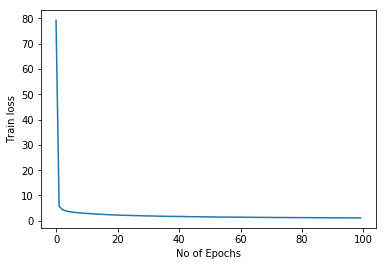

In [0]:
plt.plot(epochs, train_loss)
plt.ylabel('Train loss')
plt.xlabel('No of Epochs')
plt.show()

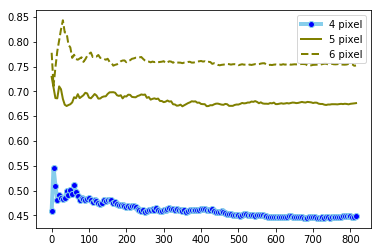

In [0]:
df=pd.DataFrame({'x': range(0,818,5), '4 pixel': acc, '5 pixel': acc_1, '6 pixel': acc_2 })


plt.plot( 'x', '4 pixel', data=df, marker='.', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
plt.plot( 'x', '5 pixel', data=df, marker='', color='olive', linewidth=2)
plt.plot( 'x', '6 pixel', data=df, marker='', color='olive', linewidth=2, linestyle='dashed')
plt.legend()